In [1]:
import ee
import geemap
import geopandas as gpd
import numpy as np
from agroforestry.config import * 
from agroforestry.geeHelpers import *
from agroforestry.naipProcessing import *
from agroforestry.snicProcessing import *
from agroforestry.randomForest import *
from agroforestry.exportFunctions import *

In [2]:
# establish connection with ee account. might require some additional configuration based on local machine 
ee.Initialize()

<Axes: >

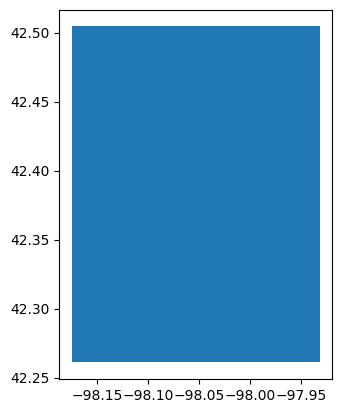

In [3]:
# define the aoi
aoiID = initGridID # something to itorate over for now is defined based on the input training dataset 
# this becomes the AOI to used in the prepNAIP function. I'll need to edit it so that it converts the input data into a bbox 
gridSelect = grid.loc[grid.Unique_ID == aoiID]
# create a sub grid for downloading 
downloadGrids = create_grid(gdf=gridSelect,n_cells=5,crs=gridSelect.crs)
# convert to a gee object 
aoi1 = geemap.gdf_to_ee(gridSelect)

# generate the USDA reference object 
aoi2 = geemap.gdf_to_ee(downloadGrids)
downloadGrids.plot()

In [6]:
Map = geemap.Map(center=(42.3, -98), zoom=10)
Map.addLayer(aoi1, {'color': '000000ff',
                    'width': 2,
                    'lineType': 'solid'},
             'area of interest')
Map.addLayer(aoi2, {'color': '000000ff',
                    'width': 2,
                    'lineType': 'solid'},
             'area of subgrid')
Map.add_basemap('HYBRID')
# Map

In [7]:
# import training dataset 
trainingData = gpd.read_file(filename="data/processed/trainingdataset_withClasses.geojson")
# print(type(trainingData))
# select the training class of interest and drop unnecessary columns
trainingSubset =  trainingData[trainingData.sampleStrat == "subgrid"]
# print(trainingSubset)
# convert to ee object
pointsEE = geemap.gdf_to_ee(gdf=trainingSubset)
# subset testing and training data 
training = pointsEE.filter(ee.Filter.gt('random', test_train_ratio))
testing = pointsEE.filter(ee.Filter.lte('random',test_train_ratio))
# traing the rf model 
rfCluster = trainRFModel(bands=bandsToUse_Cluster, inputFeature=training, nTrees=nTrees,setSeed=setSeed)
rfPixel = trainRFModel(bands=bandsToUse_Pixel, inputFeature=training, nTrees=nTrees,setSeed=setSeed)
rfPixelTrim = trainRFModel(bands=vsurfNoCor,  inputFeature=training, nTrees=nTrees,setSeed=setSeed )
## run validation using the testing set 
clusterValidation = testRFClassifier(classifier=rfCluster, testingData= testing)
pixelValidation = testRFClassifier(classifier=rfPixel, testingData= testing)
pixelValidationTrim = testRFClassifier(classifier=rfPixelTrim, testingData= testing)

In [21]:
# cant print tuple with this function
geePrint(pixelValidationTrim)

0.9891304347826086


In [15]:
# cant print tuple with this function
geePrint(pixelValidation)
# strange that these are both the same value... 

0.967391304347826


In [8]:
# generate NAIP layer 
naipEE = prepNAIP(aoi=aoi1, year=year,windowSize=windowSize)

# normal the naip data
# normalizedNAIP = normalize_by_maxes(img=naipEE, bandMaxes=bandMaxes)

# produce the SNIC object 
snicData = snicOutputs(naip = naipEE,
                       SNIC_SeedShape = SNIC_SeedShape, 
                       SNIC_SuperPixelSize = SNIC_SuperPixelSize, 
                       SNIC_Compactness = SNIC_Compactness, 
                       SNIC_Connectivity = SNIC_Connectivity,
                       # nativeScaleOfImage = nativeScaleOfImage, 
                       bandsToUse_Cluster = bandsToUse_Cluster)
geePrint(snicData.bandNames())


['R_mean', 'G_mean', 'B_mean', 'N_mean', 'nd_mean', 'contrast_g_mean', 'corr_g_mean', 'entropy_g_mean', 'contrast_n_mean', 'corr_n_mean', 'entropy_n_mean', 'R', 'G', 'B', 'N', 'contrast_g', 'corr_g', 'entropy_g', 'contrast_n', 'corr_n', 'entropy_n', 'nd', 'nd_sd_neighborhood', 'nd_mean_neighborhood']


In [9]:
# apply the rf model to the cluster imagery 
classifiedClusters = applyRFModel(imagery=snicData, bands=bandsToUse_Cluster, classifier=rfCluster)
geePrint(classifiedClusters.bandNames())

# apply the rf model to the pixels 
classifiedPixels = applyRFModel(imagery=snicData, bands=bandsToUse_Pixel,classifier=rfPixel)
# trim RF model 
classifiedPixelsTrim = applyRFModel(imagery=snicData, bands=vsurfNoCor,classifier=rfPixelTrim)

# generate the ensamble model 
combinedModels = classifiedPixels.add(classifiedClusters)
# reclass the image so it is a 0,1 value set 
from_list = [0, 1, 2]
# A corresponding list of replacement values (10 becomes 1, 20 becomes 2, etc).
to_list = [0, 0, 1]
combinedModelsReclass =  combinedModels.remap(from_list, to_list, bandName='classification').clip(aoi1.geometry())
# geePrint(combinedModelsReclass)

['classification']


In [10]:
# Set visualization parameters.
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['#f5f7f710', '#10c9a1'],
}
Map.addLayer(classifiedClusters, vis_params,'cluster Model')
Map.addLayer(classifiedPixels, vis_params,'pixel Model')
Map.addLayer(combinedModelsReclass, vis_params,'combined Model')
Map.addLayer(classifiedPixelsTrim, vis_params,'trim pixel Model')

Map

Map(center=[42.3, -98], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…